In [1]:
using PyPlot, Random, LinearAlgebra, Statistics

Code for the paper L. Chizat, P. Netrapalli (2023). "Steering Deep Feature Learning with Backward Aligned Feature Updates".

# RESNETS architecture

In [2]:
"""
Forward pass in a ReLU Resnet, basic architecture 
input: X, Y, weight matrices Ws (list of matrices of length L), compatible sizes
output: Fs, Ps all the forward pass (here activations)
"""

# random Gaussian initialization
function init_ResNet2(d,m,k,L)
    Ws = Vector{Any}(undef, L)
    Vs = Vector{Any}(undef, L)
    Ws[1] = randn(m,d)/sqrt(d) #6in pdf
    for k=2:L-1
        Ws[k] = diagm(ones(m)) # in case one want to add another layer of weights before non-linearity
        Vs[k] = randn(m,m)*sqrt(2/m) #we'll put the scales in the architecture
    end
    Ws[L] = randn(k,m)*1/m 
    return Ws, Vs
end

function forward_ResNet2(X,Y,Ws,Vs,β) #1 embedding, 1 de-embedding layer, and L-2 resnet layers
    L = length(Ws)
    As = Vector{Any}(undef, L)  # activations (cut nodes)
    Ps = Vector{Any}(undef, L)  # pre-activations (inside residual
    Qs = Vector{Any}(undef, L)  # activations (inside residual)
    Ps[1] = X 
    As[1] = Ws[1]*X
    a = 0.0
    for k = 2:L-1
        Ps[k] = Ws[k]*As[k-1]
        Qs[k] = max.(0.0, Ps[k])
        As[k] = sqrt(1-β^2)*As[k-1] + β*Vs[k]*Qs[k]
    end
    Ps[L] = Ws[L]*As[L-1]
    As[L]= sum( (1/2)*(Ps[L] .- Y).^2)/length(Y)
    return As, Ps, Qs
end

# gradients of the pre-activations
function backward_ResNet2(As,Ps,Qs,Y,Ws,Vs,β)
    L = length(Ws)
    BAs = Vector{Any}(undef, L)  # activations' gradients
    BPs = Vector{Any}(undef, L)  # pre-activations' gradients
    BQs = Vector{Any}(undef, L)  # pre-activations' gradients
    BAs[L] = 1.0
    BPs[L] = (Ps[L] .- Y)/length(Y)
    BAs[L-1] = Ws[L]'*BPs[L]
    for k = L-1:-1:2
        BQs[k] = β*Vs[k]'*BAs[k]
        BPs[k] = (Ps[k] .> 0.0) .* BQs[k]
        BAs[k-1] = Ws[k]'*BPs[k] + sqrt(1-β^2)*BAs[k]
    end
    BPs[1] = Ws[1]'*BAs[1]
    #@show size(BAs[1]), size(Ps[1])
    return BAs, BPs, BQs
end

function weight_update_ResNet2!(Ws,Vs,X,As,Ps,Qs,BAs, BPs,BQs,η; FSC=false)
    L= length(Ws)
    dW = BAs[1]*Ps[1]'
   # @show size(BAs[1]), size(Ps[1]), size(Ws[1])
    if FSC
   #     Ws[1] = Ws[1] .- η*dW/(sum(dW.^2)*L)
    else
   # Ws[1] = Ws[1] .- η*dW
    end
    for k = 2:L-1
        #dW = BPs[k]*As[k-1]'
        dV = BAs[k]*Qs[k]'
        if FSC
            #Ws[k] = Ws[k] .- η*dW/(sum(dW.^2)*L)
            Vs[k] = Vs[k] .- η*dV/(sum(dV.^2)*L)
        else
            #Ws[k] = Ws[k] .- η*dW
            Vs[k] = Vs[k] .- η*dV
        end
    end
end

weight_update_ResNet2! (generic function with 1 method)

## 1/ Observables versus layer index

In [27]:
d,m,k,L = 10,200,1,200
X = randn(d)/sqrt(d)
Y = randn(k)/sqrt(k)
η0 = 0.001
βs = [1/L,0.5/sqrt(L),1/sqrt(L),2/sqrt(L),1.0] 

ntrial=5
magnitude_f = zeros(ntrial,length(βs),L-1)
magnitude_S = zeros(ntrial,length(βs),L-1)
magnitude_df = zeros(ntrial,length(βs),L-1)
magnitude_db = zeros(ntrial,length(βs),L-1)
magnitude_dfa = zeros(ntrial,length(βs),L-1)
align_angle  = zeros(ntrial,length(βs),L-1)

@time for j=1:ntrial
    for i = 1:length(βs)
        β=βs[i]
        Ws,Vs = init_ResNet2(d,m,k,L)
        A1, P1, Q1 = forward_ResNet2(X,Y,Ws,Vs,β)
        BA1, BP1, BQ1 = backward_ResNet2(A1,P1,Q1,Y,Ws,Vs,β);
        weight_update_ResNet2!(Ws, Vs, X, A1, P1, Q1, BA1, BP1, BQ1, η0, FSC=true)
        A2, P2, Q2 = forward_ResNet2(X,Y,Ws,Vs,β);
        BA2, BP2, BQ2 = backward_ResNet2(A2,P2,Q2,Y,Ws,Vs,β);

        magnitude_f[j,i,:] = [norm(A1[k])/sqrt(m) for k=1:L-1]
        magnitude_S[j,i,:] = [1 ./(norm(BA1[k])*sqrt(m)) for k=1:L-1]
        magnitude_dfa[j,i,:]= [(dot(A1[k] .- A2[k],BA1[k])/(norm(BA1[k])))/(sqrt(m)*η0) for k=1:L-1]
        magnitude_df[j,i,:] = [norm(A1[k] .- A2[k])/(sqrt(m)*η0) for k=1:L-1]
        magnitude_db[j,i,:] = [norm(BA2[k] .- BA1[k])/η0 for k=1:L-1]
        
        align_angle[j,i,:]= acos.(max.(-1.0,min.(1.0,magnitude_dfa[j,i,:]./magnitude_df[j,i,:])))
    end
end


  5.436569 seconds (829.04 k allocations: 17.934 GiB, 39.23% gc time, 2.89% compilation time)


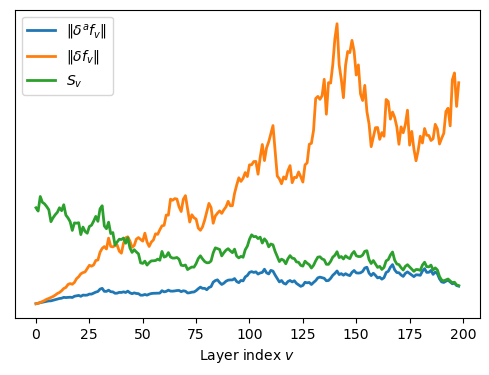

In [30]:
figure(figsize=[6,4])
j=2
plot(magnitude_dfa[j,end,:]',label=L"\Vert \delta^a f_v\Vert ",lw=2)
plot(magnitude_df[j,end,:]',label=L"\Vert \delta f_v\Vert",lw=2)
plot(magnitude_S[j,end,:],label=L"S_v",lw=2)
#plot(magnitude_db[j,end,1:L-1],label=L"\delta b_v",lw=2)
yticks([])
xlabel(L"Layer index $v$")
legend()
#savefig("bafu_vs_depth_10_200_1_MLP.png",bbox_inches="tight",dpi=200)

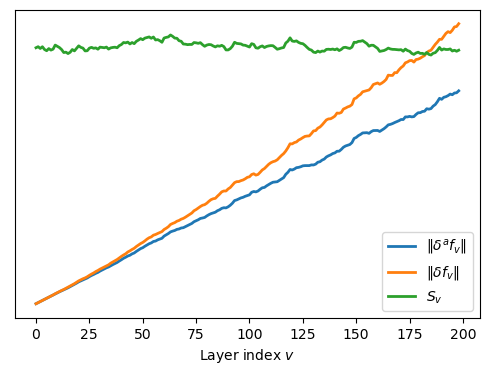

In [33]:
figure(figsize=[6,4])

plot(magnitude_dfa[j,3,:]',"C0",label=L"$\Vert \delta^a f_v\Vert$",lw=2)
plot(magnitude_df[j,3,:]',"C1",label=L"$\Vert \delta f_v\Vert$",lw=2)
plot(magnitude_S[j,3,:]'/12,"C2",lw=2, label=L"S_v")
legend()
yticks([])
xlabel(L"Layer index $v$")
#savefig("bafu_vs_depth_10_200_1_beta.png",bbox_inches="tight",dpi=200)

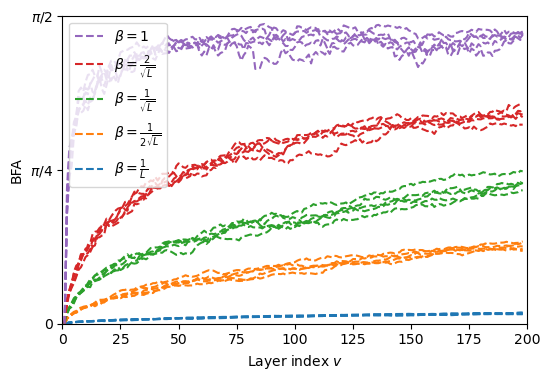

In [35]:
figure(figsize=[6,4])
for k=1:1
     plot(align_angle[k,5,:],"--C4",label=L"$\beta=1$")
    plot(align_angle[k,4,:],"--C3",label=L"$\beta=\frac{2}{\sqrt{L}}$")
    plot(align_angle[k,3,:],"--C2",label=L"$\beta=\frac{1}{\sqrt{L}}$")
    plot(align_angle[k,2,:],"--C1",label=L"$\beta=\frac{1}{2\sqrt{L}}$")
    plot(align_angle[k,1,:],"--C0",label=L"$\beta=\frac{1}{L}$")
end
for k=2:ntrial
    plot(align_angle[k,1,:],"--C0")
    plot(align_angle[k,2,:],"--C1")
    plot(align_angle[k,3,:],"--C2")
    plot(align_angle[k,4,:],"--C3")
    plot(align_angle[k,5,:],"--C4")
end
yticks([0,π/4,π/2],["0",L"\pi/4",L"\pi/2"])
axis([0,L,0,π/2])
#grid("on")
ylabel("BFA")
xlabel(L"Layer index $v$")
legend()
#savefig("alignment_vs_depth_10_200_1_beta.png",bbox_inches="tight",dpi=200)

## 2/ Angle *at output* versus depth 

In [36]:
Ls= 10:1:200
d,m,k = 10,200,1

X = randn(d)/sqrt(d)
Y = randn(k)/sqrt(k)
# always keep the same random matrices (to reduce randomness)
amax_A = zeros(length(Ls),length(βs))

@time for i=1:length(Ls)
    @show i
        for j=1:length(βs)
            L = Ls[i]
            βs = [1/L,0.5/sqrt(L),1/sqrt(L),2/sqrt(L),0.999] 
            β = βs[j]
            Ws,Vs = init_ResNet2(d,m,k,L)
            A1, P1, Q1 = forward_ResNet2(X,Y,Ws,Vs,β)
            BA1, BP1, BQ1 = backward_ResNet2(A1,P1,Q1,Y,Ws,Vs,β);
            weight_update_ResNet2!(Ws, Vs, X, A1, P1, Q1, BA1, BP1, BQ1, 0.001, FSC=true)
            A2, P2, Q2 = forward_ResNet2(X,Y,Ws,Vs,β);
            align_A = [ (dot(A1[k] .- A2[k],BA1[k])/(norm(A1[k] .- A2[k])*norm(BA1[k]))) for k=1:L-1]
            amax_A[i,j] = align_A[end]
    end
end

i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 138
i = 

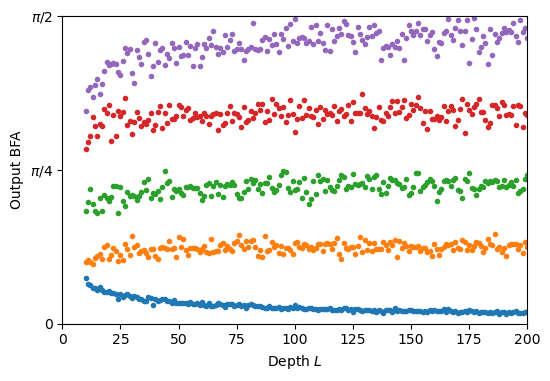

In [38]:
figure(figsize=[6,4])
plot(Ls,(acos.(min.(amax_A[:,1],1.0))),label=L"$\beta=\frac{1}{L}$",lw=2,".C0")
#plot(Ls,(acos.(min.(amax_MLP_P,1.0))),lw=2,":C0")
plot(Ls,(acos.(min.(amax_A[:,2],1.0))),label=L"$\beta=\frac{1}{2\sqrt{L}}$",lw=2,".C1")
#plot(Ls,(acos.(min.(amax_ResNet1_P,1.0))),lw=2,":C1")
plot(Ls,(acos.(min.(amax_A[:,3],1.0))),label=L"$\beta=\frac{1}{\sqrt{L}}$",lw=2,".C2")
#plot(Ls,(acos.(min.(amax_ResNet11_P,1.0))),lw=2,":C2")
plot(Ls,(acos.(min.(amax_A[:,4],1.0))),label=L"$\beta=\frac{2}{\sqrt{L}}$",lw=2,".C3")
#plot(Ls,(acos.(min.(amax_ResNet2_P,1.0))),lw=2,":C3")
plot(Ls,(acos.(min.(amax_A[:,5],1.0))),label=L"$\beta=1$",lw=2,".C4")
#plot(Ls,(acos.(min.(amax_ResNet2_P,1.0))),lw=2,":C3")
axis([0,Ls[end],0,π/2])
yticks([0,π/4,π/2],["0",L"\pi/4",L"\pi/2"])
#grid("on")
ylabel("Output BFA")
xlabel(L"Depth $L$")
#legend()
#savefig("alignment_vs_L_10_200_1_beta.png",bbox_inches="tight",dpi=200)

## 3/ Output angle vs $c$ when $\beta=c/\sqrt{L}$

In [41]:
# need to repeat "by hand" while change depth L
d,m,k,L = 10,500,1,500
βs = 10 .^(range(-3,0.0,length=20))
tab2 = zeros(5,length(βs))

@time for k=1:5
    @show k
for i = 1:length(βs)
β=βs[i]
Ws,Vs = init_ResNet2(d,m,k,L)
A1, P1, Q1 = forward_ResNet2(X,Y,Ws,Vs,β)
BA1, BP1, BQ1 = backward_ResNet2(A1,P1,Q1,Y,Ws,Vs,β);
weight_update_ResNet2!(Ws, Vs, X, A1, P1, Q1, BA1, BP1, BQ1, 0.001, FSC=true)
A2, P2, Q2 = forward_ResNet2(X,Y,Ws,Vs,β);
tab2[k,i]= (dot(A1[L-1] .- A2[L-1],BA1[L-1])/(norm(A1[L-1] .- A2[L-1])*norm(BA1[L-1])))
    
    end
end
#plot(acos.(align_ResNet11_P ))
#plot(acos.(align_ResNet11_Q ))

k = 1
k = 2
k = 3
k = 4
k = 5
204.562772 seconds (3.20 M allocations: 1023.533 GiB, 15.38% gc time)


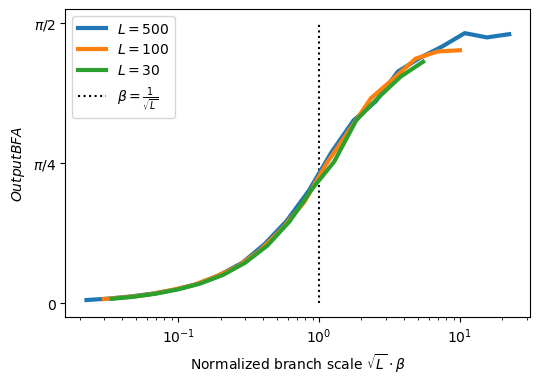

PyObject Text(0.5, 32.83333333333333, 'Normalized branch scale $\\sqrt{L}\\cdot\\beta$')

In [42]:
figure(figsize=[6,4])
semilogx(βs*sqrt(500),sum(acos.(tab2),dims=1)'/5,lw=3,"C0",label=L"L=500") #tab2=500
semilogx(βs[4:end]*sqrt(100),sum(acos.(tab3[:,4:end]),dims=1)'/5,lw=3,"C1",label=L"L=100") #tab3=100
semilogx(βs[6:end]*sqrt(30),sum(acos.(tab4[:,6:end]),dims=1)'/5,lw=3,"C2",label=L"L=30") #tab4=100
#axis([0.001,1,0,π/2])
yticks([0,π/4,π/2],["0",L"\pi/4",L"\pi/2"])
vlines(1,0,π/2,"k",":",label=L"\beta=\frac{1}{\sqrt{L}}")
legend()
ylabel(L"Output BFA")
xlabel(L"Normalized branch scale $\sqrt{L}\cdot\beta$")
#savefig("alignment_vs_scale_10_500_1_beta.png",bbox_inches="tight",dpi=200)